In [ ]:
# import the required libraries
import numpy as np
import pandas as pd
from time import time
import seaborn as sns
import matplotlib.pyplot as plt

import xgboost as xgb
from sklearn.svm import SVR
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet

from sklearn.model_selection import train_test_split, GridSearchCV, LeaveOneOut
from sklearn.metrics import r2_score, mean_squared_error

In [ ]:
sns.set(font_scale=1.5)

In [ ]:
# read the final csv data 
data = pd.read_csv("Data/resd_features.csv")
data.shape

(191, 9)

In [ ]:
data.describe()

,surface,n_bhk,sa1,pool,sa9,sa7,sa2,sa5,price
count,1.910000e+02,191.000000,191.000000,191.000000,191.000000,191.00000,191.000000,191.000000,191.000000
mean,-9.300298e-18,2.471204,0.062827,0.628272,0.041885,0.08377,0.052356,0.052356,8.712707
std,1.002628e+00,1.186751,0.243290,0.484536,0.200852,0.27777,0.223329,0.223329,5.860711
min,-1.646923e+00,1.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,1.319000
25%,-6.084823e-01,2.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,5.078000
50%,-2.729862e-01,2.000000,0.000000,1.000000,0.000000,0.00000,0.000000,0.000000,7.000000
75%,4.179761e-01,3.000000,0.000000,1.000000,0.000000,0.00000,0.000000,0.000000,9.793500
max,4.123078e+00,9.000000,1.000000,1.000000,1.000000,1.00000,1.000000,1.000000,46.000000


In [ ]:
d = {'baner': 'sa1',
 'bavdhan': 'sa2',
 'bt kawade rd': 'sa3',
 'hadapsar': 'sa4',
 'handewadi': 'sa5',
 'hinjewadi': 'sa6',
 'kharadi': 'sa7',
 'mahalunge': 'sa8',
 'nibm': 'sa9',
 'other': 'sa10',
 'ravet': 'sa11',
 'wadgaon sheri': 'sa12'}
d

{'baner': 'sa1',
 'bavdhan': 'sa2',
 'bt kawade rd': 'sa3',
 'hadapsar': 'sa4',
 'handewadi': 'sa5',
 'hinjewadi': 'sa6',
 'kharadi': 'sa7',
 'mahalunge': 'sa8',
 'nibm': 'sa9',
 'other': 'sa10',
 'ravet': 'sa11',
 'wadgaon sheri': 'sa12'}

In [ ]:
# sa1: baner, sa9: nibm, sa7: kharadi, sa2: bavdhan, sa5: handewadi

## Data prepration

In [ ]:
data = data.sort_values("surface").reset_index(drop=True)
data.head()

,surface,n_bhk,sa1,pool,sa9,sa7,sa2,sa5,price
0,-1.646923,1.0,0,1,0,0,0,0,1.319
1,-1.540416,1.0,0,1,0,0,0,0,1.400
2,-1.385981,1.0,0,0,0,0,0,0,3.300
3,-1.367343,2.0,0,0,0,0,0,0,1.729
4,-1.348704,1.0,0,0,0,0,1,0,3.949


In [ ]:
# Selecting the feature matrix and target vector
X = data.iloc[:, :-1]
y = data["price"]


In [ ]:
# Random state for data splitting
rs = 118 
# compare the result of different models so we need same data, 
# fixed random_state in in train_test_split gives same data samples all times..

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.3, random_state=rs) 

In [ ]:
# function for performing grid search
def gridSearchReport( estimator, X, y, pg, cv=LeaveOneOut(), rs=118 ):
    """
    Performs the grid search and cross validation for the given regressor.
    Params:
        estimator:  the regressor
        X: Pandas dataframe, feature data
        y: Pandas series, target
        pg: dict, parameters' grid
        cv: int, cross-validation generator or an iterable, cross validation folds
        rs: int, training-test split random state
    """    

    t0 = time()
    
    X_train, X_test, y_train, y_test = \
        train_test_split(X, y, test_size=.3, random_state=rs) # train tets split
    
    est_cv = GridSearchCV(
        estimator, 
        param_grid=pg, 
        scoring="neg_mean_squared_error", 
        n_jobs=-1, 
        cv=cv
       )
    
    est_cv.fit(X_train, y_train)
    
    print("Best parameters:", est_cv.best_params_) # best parameters
    print("Best CV score:", abs(est_cv.best_score_)) # cross validation score
    y_train_pred, y_test_pred = est_cv.predict(X_train), est_cv.predict(X_test) # predictions on train and test data
    print("MSE, R2 train:", mean_squared_error(y_train, y_train_pred),  # evaluation metrics
          ", ", r2_score(y_train, y_train_pred) )
    print("MSE, R2 test:", mean_squared_error(y_test, y_test_pred),
          ", ", r2_score(y_test, y_test_pred) )
    
    t = round(time()-t0, 2)
    print("Elapsed time:", t, "s ,", round(t/60, 2), "min")
    
    return est_cv


    

In [ ]:
# function to plot the residuals
def plotResidue(estimator, X, y, rs=118):
    """
    Plots the fit residuals (price - predicted_price) vs. "surface" variable.
    Params:
        estimator: GridSearchCV, the regressor
        X: Pandas dataframe, feature data
        y: Pandas series, target
        rs: int, random state
    """    
    X_train, X_test, y_train, y_test = \
        train_test_split(X, y, test_size=.3, random_state=rs) # train tets split

    residue_train = y_train-estimator.predict(X_train) # make predictions
    residue_test = y_test-estimator.predict(X_test)                                                     
                                                          
    fig, axe = plt.subplots(1, 2, figsize=(18,10)) 
    axe[0].scatter( X_train["surface"], residue_train, label="train" )
    axe[0].scatter( X_test["surface"], residue_test, label="test" )
    axe[0].plot( [-2.3, 4.5], [0,0], "black" )
    axe[0].set_xlabel("Scaled surface")
    axe[0].set_ylabel("Fit residulas")
    axe[0].legend()
    
    axe[1].hist(residue_test, bins=25)
    axe[1].set_xlabel("Fit residual for test set")
    axe[1].set_ylabel("Count")


    plt.show()

    print("mean residuals:", round(np.mean(residue_test), 2),
          "\nstd:", round(np.std(residue_test), 2))
    

## Ordinary Linear Regression

In [ ]:
# define a simple linear regression model
lr = LinearRegression()
lr.fit(X_train, y_train)

LinearRegression()

In [ ]:
# check for the r2 score on train and tets data
r2_score(y_train, lr.predict(X_train)),\
r2_score(y_test, lr.predict(X_test))

(0.80946990650497, 0.8125627568879954)

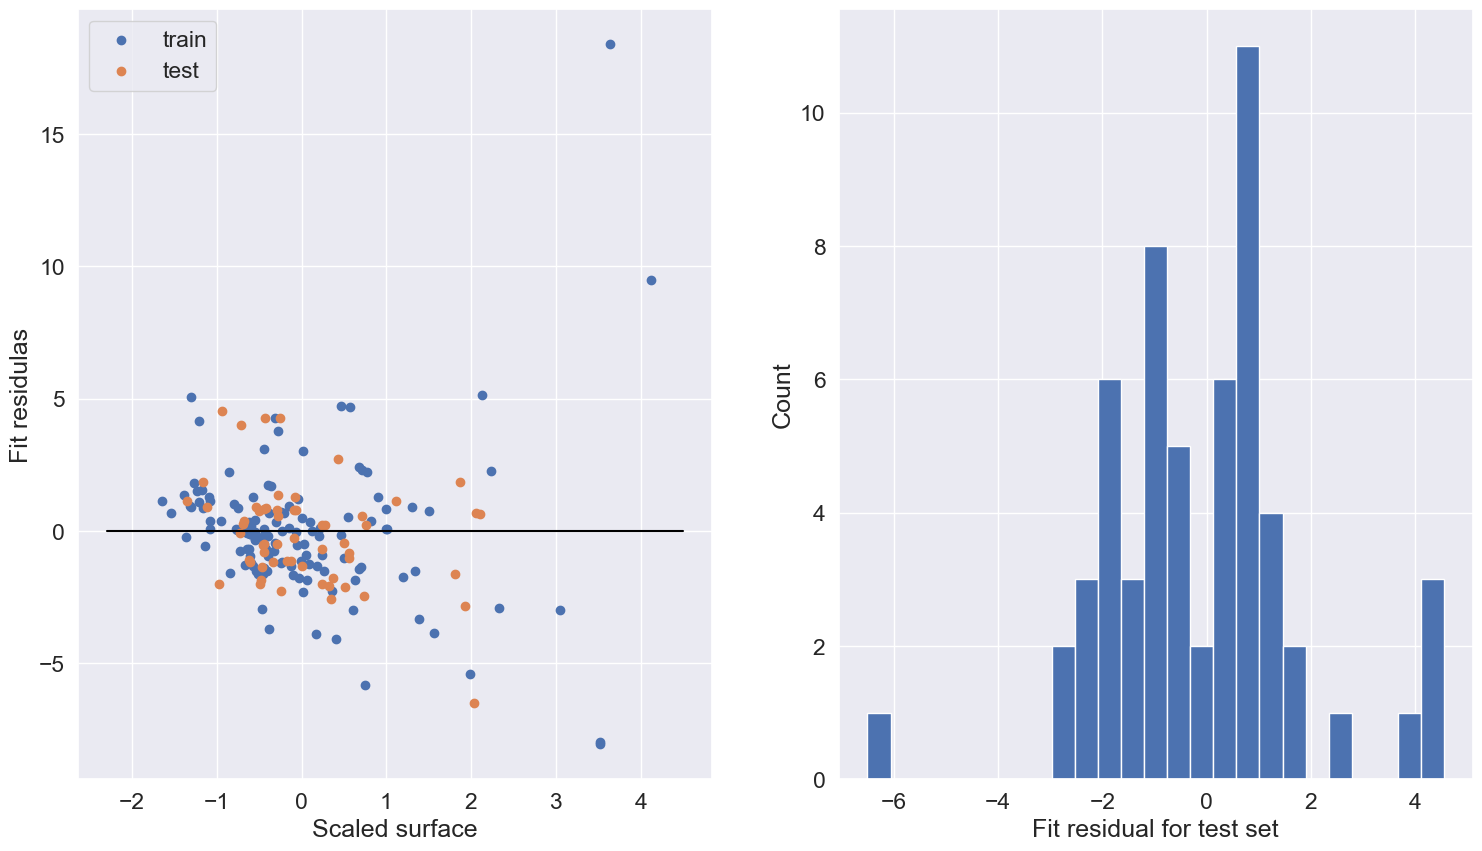

mean residuals: -0.13 
std: 1.91


In [ ]:
# plot the residuals
plotResidue(lr, X, y, rs=rs)

## Ridge Regression

In [ ]:
# define the parameters for ridge regression model and check for the grid search 
alphas = np.logspace(-3,3,100)
pg = {"alpha":alphas}
ridge = Ridge()
ridg_cv = gridSearchReport( ridge, X, y, pg, rs=rs )

Best parameters: {'alpha': 3.2745491628777286}
Best CV score: 10.41858270883159
MSE, R2 train: 7.901472037695782 ,  0.8049536453245207
MSE, R2 test: 3.447944639011366 ,  0.8241663523605839
Elapsed time: 35.09 s , 0.58 min


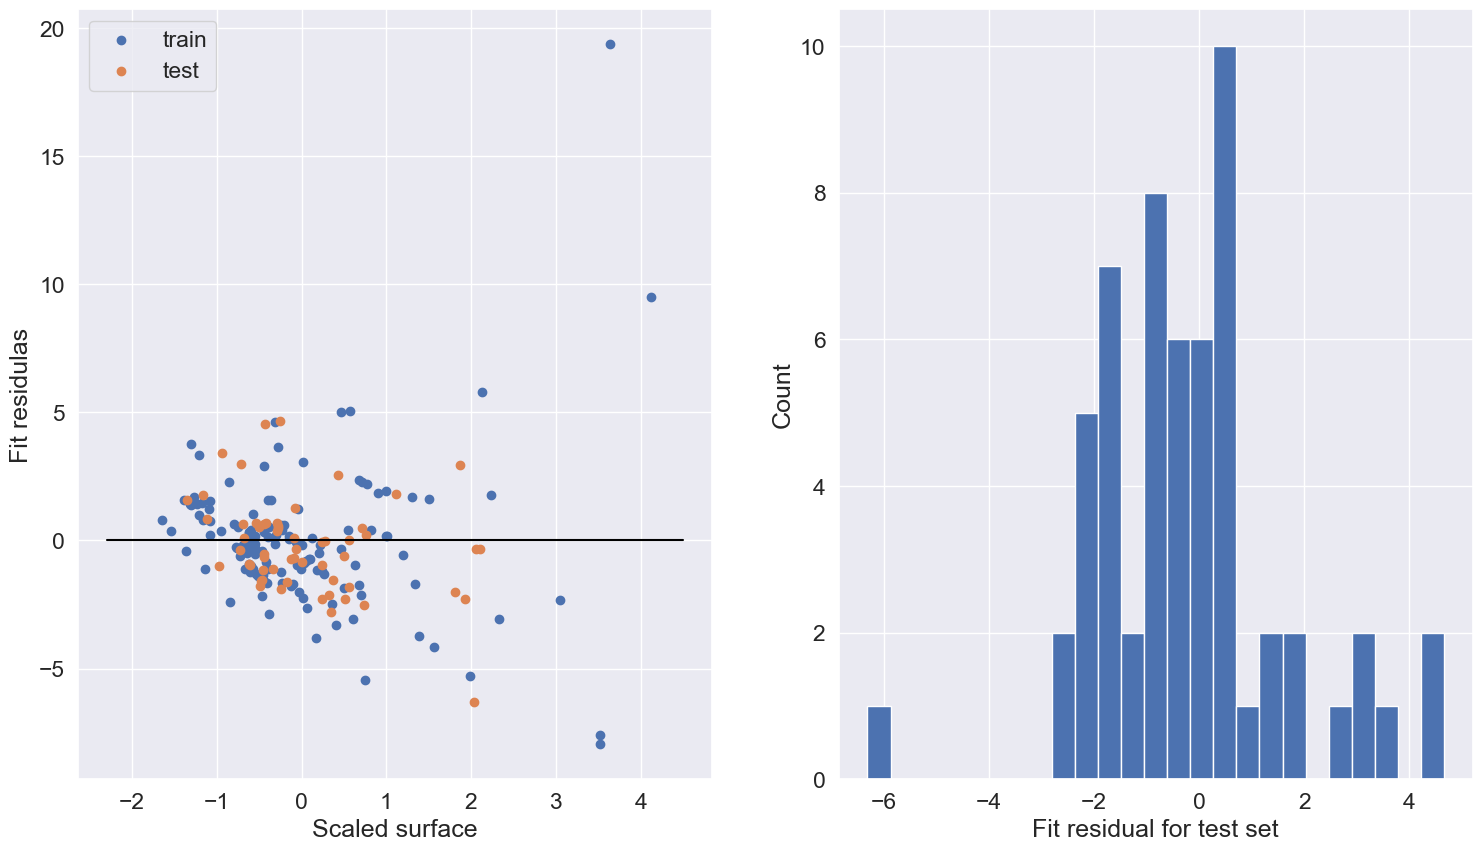

mean residuals: -0.2 
std: 1.85


In [ ]:
# plot the residuals
plotResidue(ridg_cv, X, y, rs)

## Lasso Regression

In [ ]:
# define the parameters and plot the lasso regression model
lasso = Lasso()
pg = {"alpha":alphas}
lasso_cv = gridSearchReport( lasso, X, y, pg, rs=rs )

Best parameters: {'alpha': 0.06579332246575682}
Best CV score: 10.407777867173529
MSE, R2 train: 8.027277301609049 ,  0.8018481659900112
MSE, R2 test: 3.6461669435363224 ,  0.8140576776290465
Elapsed time: 36.83 s , 0.61 min


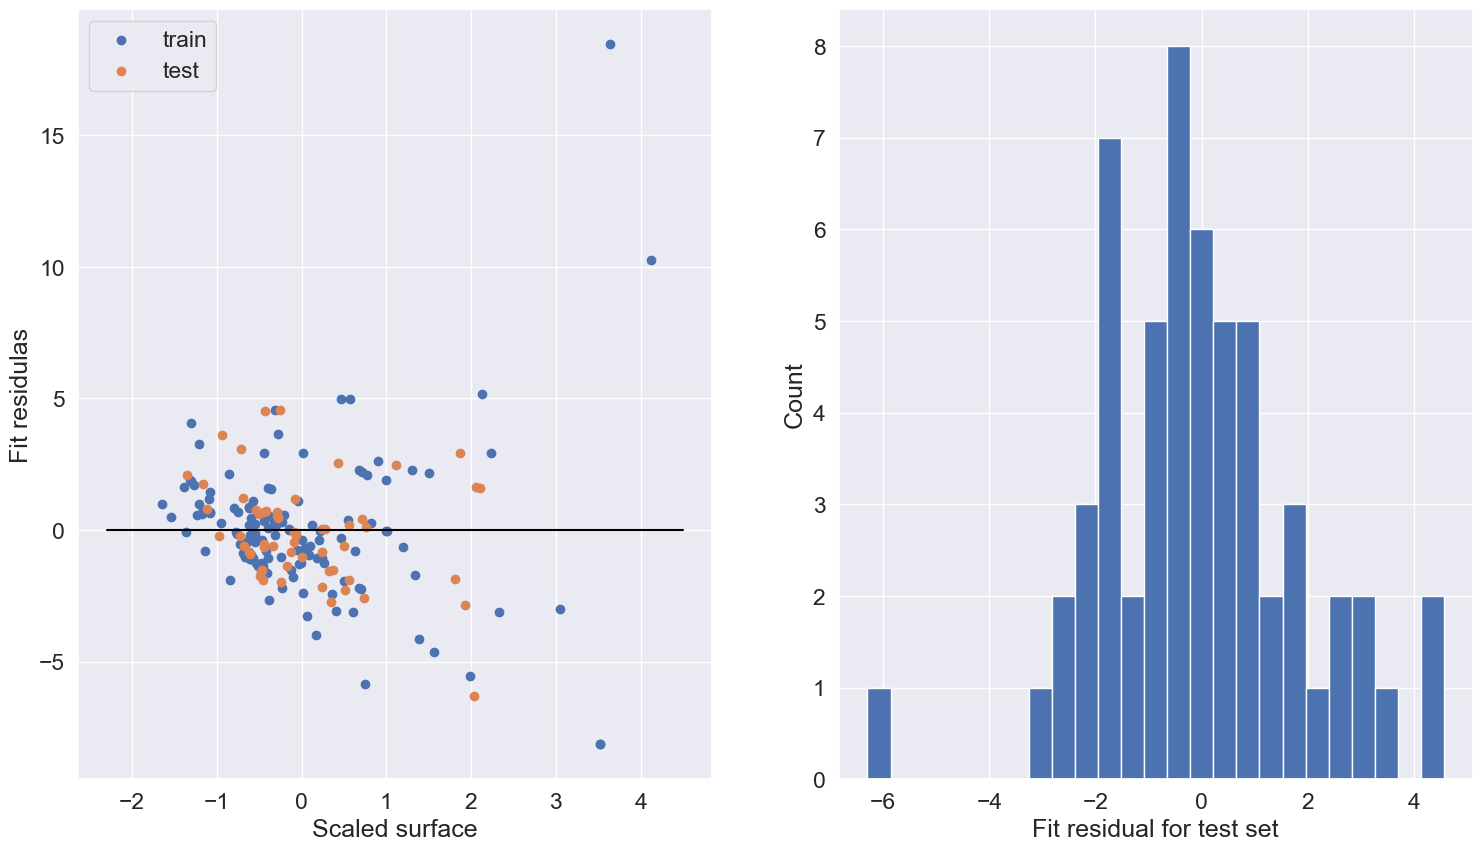

mean residuals: -0.08 
std: 1.91


In [ ]:
# plot the residuals 
plotResidue(lasso_cv, X, y, rs=rs)

## Lasso and Ridge Combination

In [ ]:
# define an elasticnet model 
l1_ratio = np.random.rand(20)
elastic = ElasticNet()
pg = {"alpha":np.linspace(0.1,1,5), "l1_ratio":l1_ratio}
elastic_cv = gridSearchReport( elastic, X, y, pg, rs=rs )

Best parameters: {'alpha': 0.1, 'l1_ratio': 0.9821691622479036}
Best CV score: 10.517430938368987
MSE, R2 train: 8.20476516386869 ,  0.7974669114126702
MSE, R2 test: 3.657877766543797 ,  0.81346046481334
Elapsed time: 39.33 s , 0.66 min


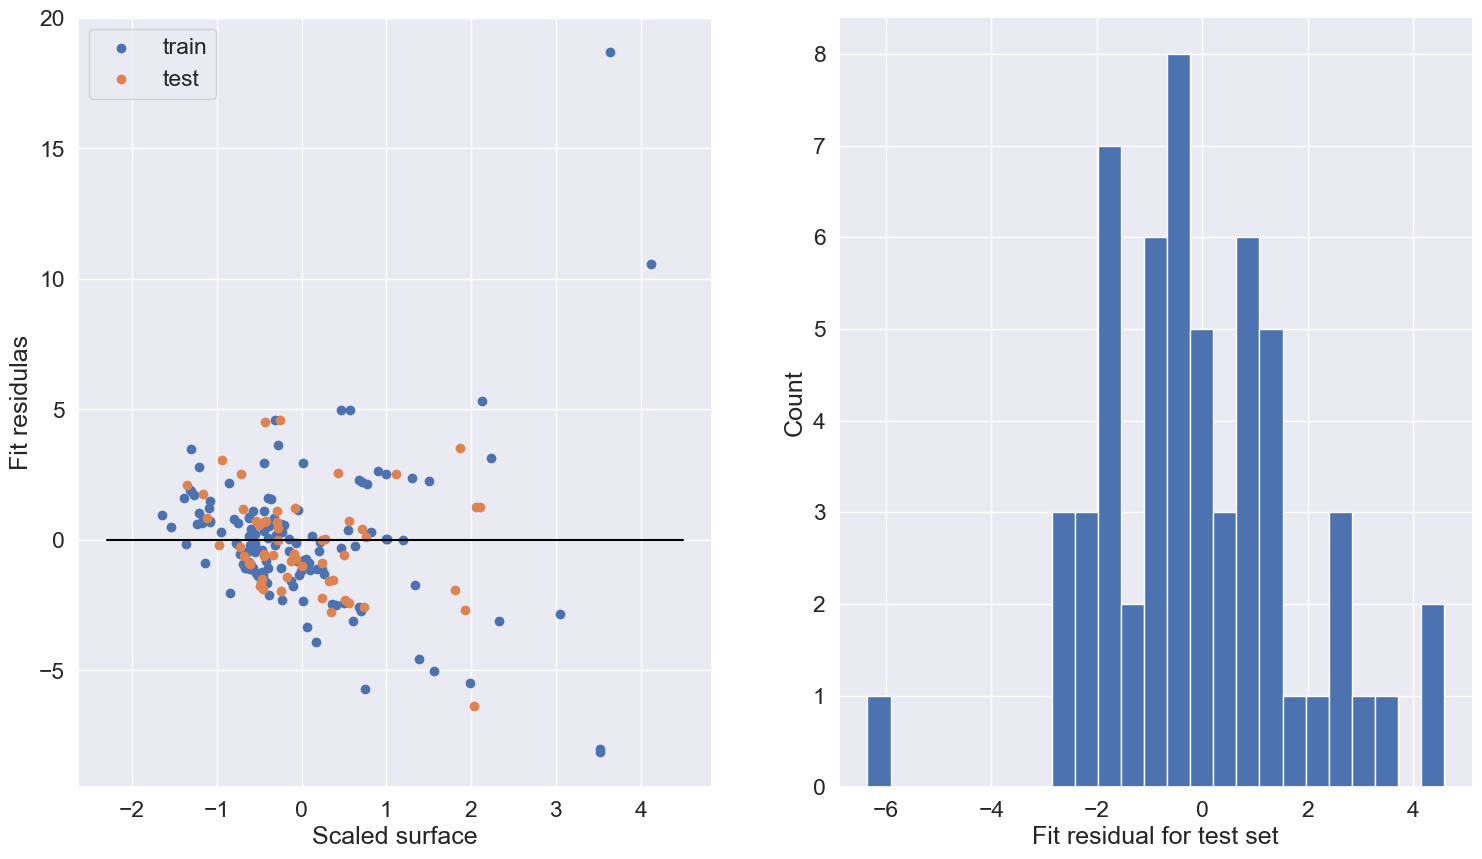

mean residuals: -0.12 
std: 1.91


In [ ]:
# plot the residuals
plotResidue(elastic_cv, X, y, rs=rs)

## Random Forest Regressor

In [ ]:
# define a random forest regression model 
rfr = RandomForestRegressor( random_state=10 )
pg = {"n_estimators":[10, 20, 30, 50],
         "criterion":["squared_error", "absolute_error", "poisson"],
         "max_depth":[2,3,4],
         "min_samples_split":range(2, 10),
         "min_samples_leaf":[2,3],
         "max_features":range(4, X_train.shape[1]+1) 
        }
rfr_cv = gridSearchReport( rfr, X, y, pg, cv=5, rs=rs )

Best parameters: {'criterion': 'squared_error', 'max_depth': 4, 'max_features': 6, 'min_samples_leaf': 2, 'min_samples_split': 7, 'n_estimators': 20}
Best CV score: 12.007545112999969
MSE, R2 train: 6.052141744334767 ,  0.8506040166211822
MSE, R2 test: 3.5341316302285803 ,  0.8197711039933901
Elapsed time: 411.31 s , 6.86 min


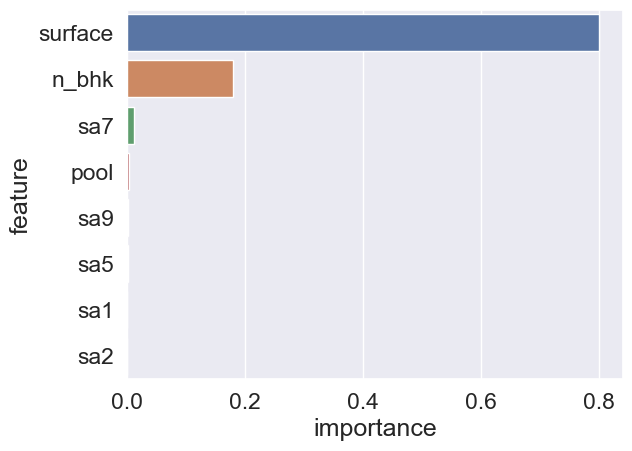

In [ ]:
# find the best features 
rfr = rfr_cv.best_estimator_
df_imp = pd.DataFrame(zip(rfr.feature_names_in_, rfr.feature_importances_))
df_imp.columns = ["feature", "importance"]
df_imp = df_imp.sort_values("importance", ascending=False).reset_index(drop=True)

sns.barplot( data=df_imp, x="importance", y="feature"  )
plt.show()

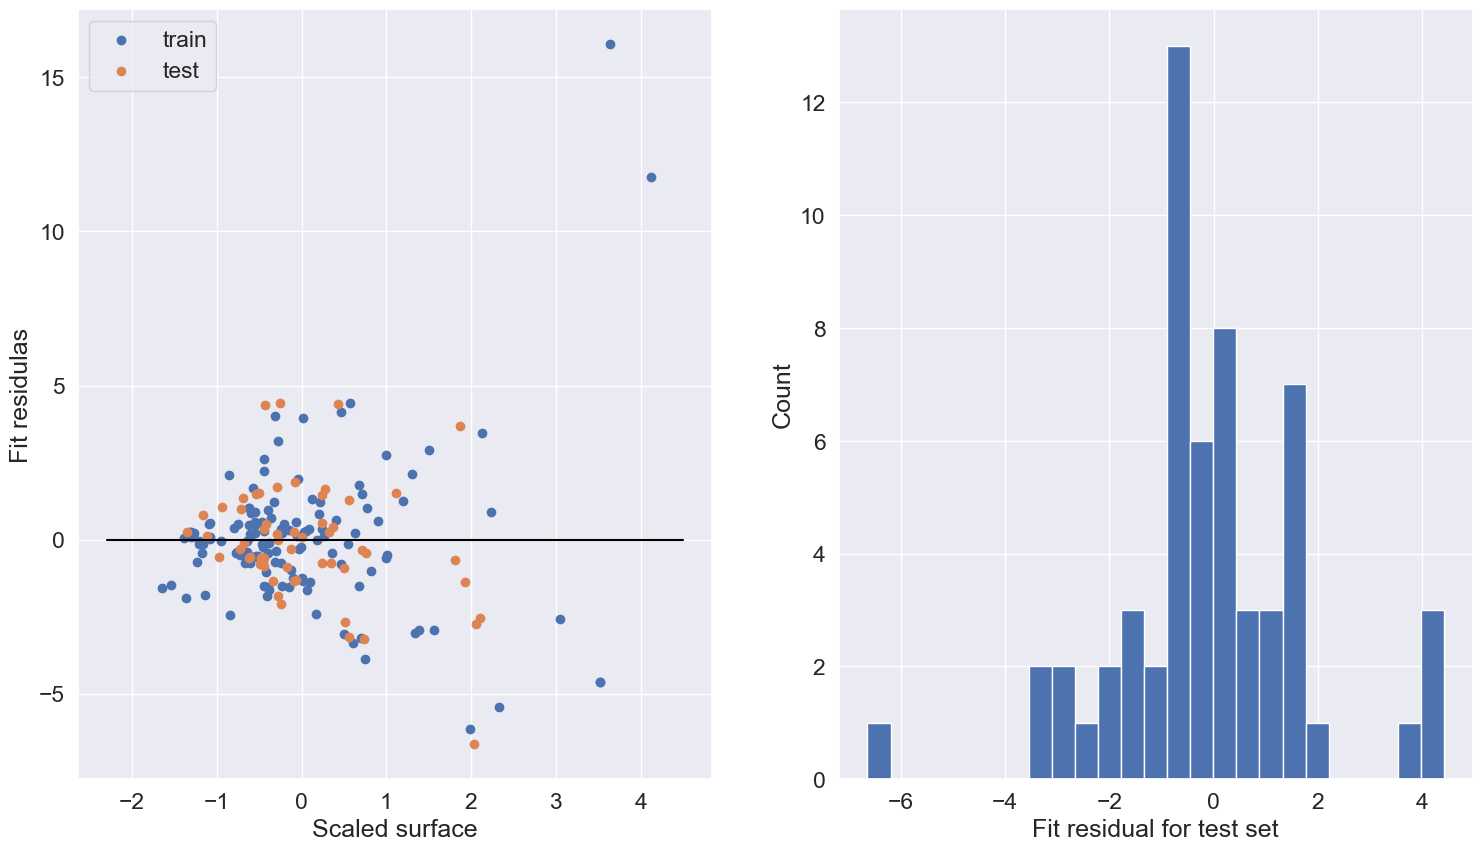

mean residuals: -0.09 
std: 1.88


In [ ]:
# plot the residuals
plotResidue(rfr_cv, X, y, rs=rs)

## XGboost (extreme gradient boosting)

In [ ]:
# define the parameters for XGBoost model
from scipy.stats import uniform
param_grid = {'max_depth':range(2,7),
      'gamma':uniform(loc=0.0, scale=3), # minimum of the loss function rduction to split a node
      'min_child_weight':range(3,6), # similar to min_samples_leaf
      'colsample_bytree':uniform(loc=0.1, scale=0.9), # similar to the max_features
      'subsample':uniform(loc=0.5, scale=0.5), # similar to bootstraping in RF
      'learning_rate':uniform(loc=0.01, scale=0.99)} # contriburion rate of each estimator

In [ ]:
from sklearn.model_selection import ParameterSampler
rng = np.random.RandomState(20)
n_iter=500
param_list = list(ParameterSampler(param_grid, n_iter=n_iter,
                                   random_state=rng))

In [ ]:
param_list[0]

{'colsample_bytree': 0.6293177209695467,
 'gamma': 2.6931411837282537,
 'learning_rate': 0.8926154221799609,
 'max_depth': 3,
 'min_child_weight': 3,
 'subsample': 0.5179447928084266}

In [ ]:
# function to perform cross validation
from sklearn.model_selection import KFold

def cross_validate( est, Xn, yn, n_fold=10 ):
    """
    Cross validation for XGB fit.
    Params:
        est: xgb regressor
        Xn: numpy array (n_sample, n_feature)
            Training feature matrix
        yn: numpy array (n_sample,)
            Training target vector
        n_fold: int
            number of folds for cross validating
    """
    kf = KFold(n_splits=n_fold, shuffle=True, random_state=0)
    mean_train_error, mean_val_error = 0., 0.
    for train_index, val_index in kf.split(Xn, yn):
        est.fit(Xn[train_index], yn[train_index], 
                    eval_set=[(Xn[train_index], yn[train_index]), 
                              (Xn[val_index], yn[val_index])],
                    eval_metric='rmse',
                    verbose=False, 
                    early_stopping_rounds=30)
        mean_val_error += mean_squared_error(yn[val_index], est.predict(Xn[val_index]))
        mean_train_error += mean_squared_error(yn[train_index], est.predict(Xn[train_index]))

    return mean_train_error/n_fold, mean_val_error/n_fold

In [ ]:
import warnings
warnings.filterwarnings('ignore')

In [ ]:
%%time
xgbr = xgb.XGBRegressor( objective='reg:squarederror', n_estimators=1000, verbosity=1 ) # XGBoost model

val_score, train_score = [], []
counter = 0
for param_grid in param_list:
    xgbr.set_params(**param_grid)
    train_error, val_error = cross_validate(xgbr, X_train.values, y_train.values)  
    val_score.append(val_error)
    train_score.append(train_error)
    
    if counter%50 == 0 :
        print("iter =", counter, 
              "train_score=", train_score[counter], ", ", 
              "val_score=", val_score[counter])
    counter += 1
        

iter = 0 train_score= 8.946462811623087 ,  val_score= 10.716667550129971
iter = 50 train_score= 8.313767132727028 ,  val_score= 10.41136319404723
iter = 100 train_score= 6.996186331183478 ,  val_score= 12.427662145788592
iter = 150 train_score= 8.485948699924936 ,  val_score= 12.895362247665451
iter = 200 train_score= 10.385781097248172 ,  val_score= 11.187461673832338
iter = 250 train_score= 7.745331702261697 ,  val_score= 11.8055963400015
iter = 300 train_score= 8.114003114048487 ,  val_score= 12.45698035361832
iter = 350 train_score= 10.778224689710425 ,  val_score= 12.775867189116312
iter = 400 train_score= 11.02281138359431 ,  val_score= 12.211450287634722
iter = 450 train_score= 7.8700688503871135 ,  val_score= 12.558649645569107
CPU times: total: 12min 48s
Wall time: 5min 41s


In [ ]:
df_grid = pd.DataFrame(param_list)
df_grid["train_score"] = train_score
df_grid["val_score"] = val_score
df_grid

,colsample_bytree,gamma,learning_rate,max_depth,min_child_weight,subsample,train_score,val_score
0,0.629318,2.693141,0.892615,3,3,0.517945,8.946463,10.716668
1,0.722582,1.136043,0.523326,4,5,0.596925,11.020271,12.094727
2,0.345085,2.155818,0.785174,3,4,0.887622,9.509731,12.088356
3,0.132998,0.350081,0.753768,4,4,0.627403,11.369185,12.339390
4,0.871863,2.849337,0.566070,2,5,0.726722,9.318870,11.883753
...,...,...,...,...,...,...,...,...
495,0.287347,1.044718,0.207315,5,4,0.521568,11.031570,11.823432
496,0.211245,2.442034,0.178679,4,3,0.501152,11.286107,13.580458
497,0.772129,2.011557,0.063765,5,3,0.881116,7.491754,12.665098
498,0.206156,1.858437,0.288957,2,3,0.929107,9.429864,13.116999


In [ ]:
df_grid_best = df_grid[ df_grid["val_score"]==min(val_score) ]
df_grid_best

,colsample_bytree,gamma,learning_rate,max_depth,min_child_weight,subsample,train_score,val_score
260,0.916952,2.420674,0.742105,2,3,0.615215,6.030669,9.323739


In [ ]:
# best parameters
best_params = df_grid_best.iloc[0, :-2].to_dict()
best_params

{'colsample_bytree': 0.9169524540404339,
 'gamma': 2.420673909578158,
 'learning_rate': 0.7421053543017646,
 'max_depth': 2.0,
 'min_child_weight': 3.0,
 'subsample': 0.6152150653228668}

In [ ]:
best_params["max_depth"] = int(best_params["max_depth"])

In [ ]:
xgbr.set_params(**best_params)
xgbr.fit(X_train, y_train, 
                eval_set=[(X_train, y_train), (X_test, y_test)],
                eval_metric='rmse',
                verbose=True, 
                early_stopping_rounds=30)


[0]	validation_0-rmse:5.02986	validation_1-rmse:3.19482
[1]	validation_0-rmse:4.12931	validation_1-rmse:2.68015
[2]	validation_0-rmse:4.04528	validation_1-rmse:2.52092
[3]	validation_0-rmse:3.90818	validation_1-rmse:2.77410
[4]	validation_0-rmse:3.91464	validation_1-rmse:3.04244
[5]	validation_0-rmse:3.64875	validation_1-rmse:2.47159
[6]	validation_0-rmse:3.46379	validation_1-rmse:2.29872
[7]	validation_0-rmse:3.56313	validation_1-rmse:2.74296
[8]	validation_0-rmse:3.39438	validation_1-rmse:2.26169
[9]	validation_0-rmse:3.31159	validation_1-rmse:2.32360
[10]	validation_0-rmse:3.14284	validation_1-rmse:2.32912
[11]	validation_0-rmse:3.09321	validation_1-rmse:2.06417
[12]	validation_0-rmse:3.17081	validation_1-rmse:1.89528
[13]	validation_0-rmse:2.86198	validation_1-rmse:2.12566
[14]	validation_0-rmse:2.82169	validation_1-rmse:2.05014
[15]	validation_0-rmse:2.78613	validation_1-rmse:2.08472
[16]	validation_0-rmse:2.73564	validation_1-rmse:1.98415
[17]	validation_0-rmse:2.69912	validation

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=0.9169524540404339, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=2.420673909578158, gpu_id=None, grow_policy=None,
             importance_type=None, interaction_constraints=None,
             learning_rate=0.7421053543017646, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=2, max_leaves=None,
             min_child_weight=3.0, missing=nan, monotone_constraints=None,
             n_estimators=1000, n_jobs=None, num_parallel_tree=None,
             predictor=None, random_state=None, ...)

In [ ]:
xgbr.get_booster().attributes()

{'best_iteration': '28',
 'best_ntree_limit': '29',
 'best_score': '1.7151941123722005'}

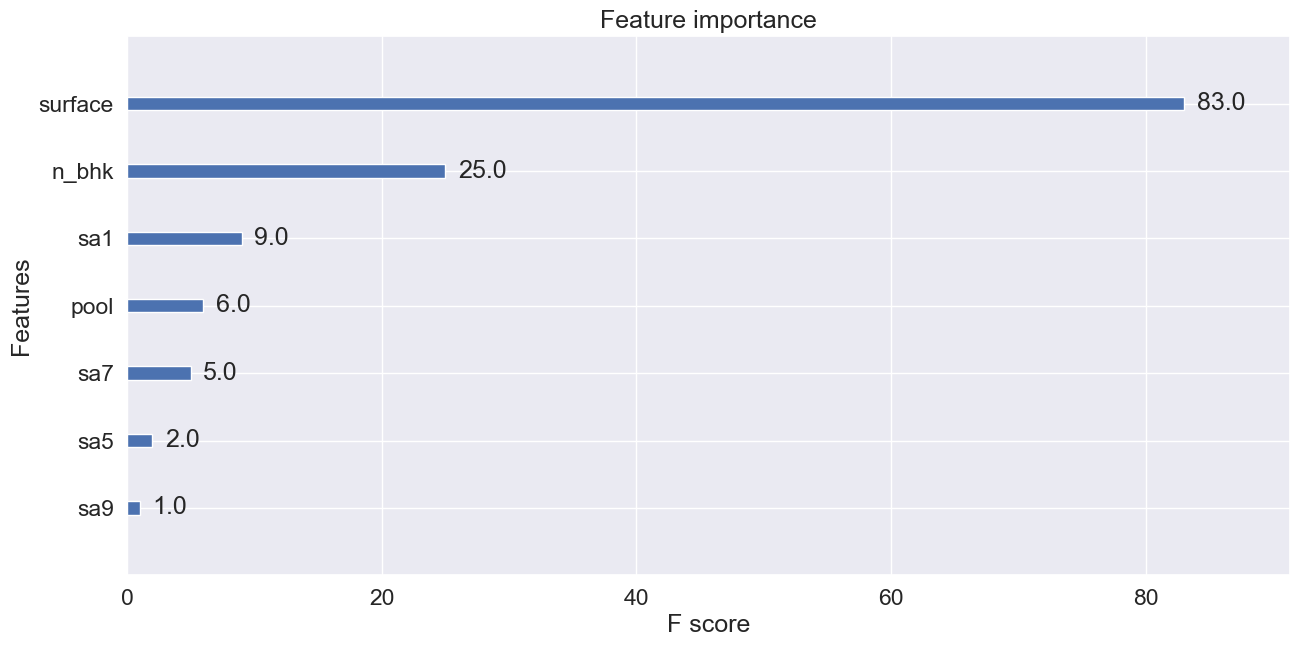

In [ ]:
# plot the feature importance 
plt.rcParams["figure.figsize"] = (15,7)
xgb.plot_importance(xgbr)
plt.show()

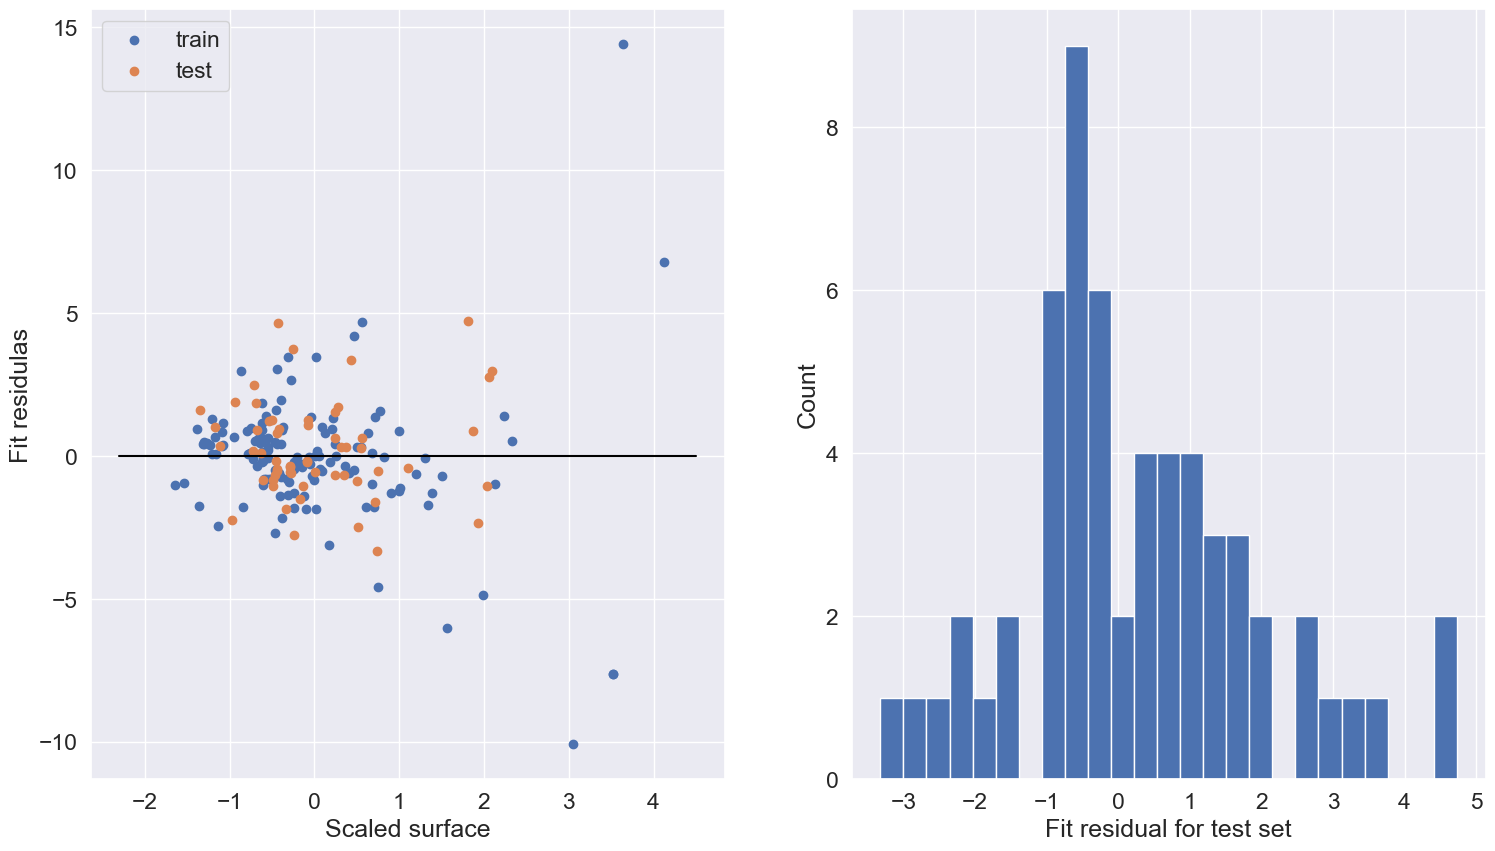

mean residuals: 0.26 
std: 1.7


In [ ]:
#  plot the residuals
plotResidue(xgbr, X, y, rs=rs)

## K-Nearest Neighbours Regression

In [ ]:
%%time
knn = KNeighborsRegressor() # KNN model
pg = {
    "n_neighbors": range(1,16),
    "weights": ['uniform', 'distance'],
    "algorithm": ['auto', 'ball_tree', 'kd_tree', 'brute']
}
knn_cv = gridSearchReport( knn, X, y, pg, rs=rs )

Best parameters: {'algorithm': 'brute', 'n_neighbors': 6, 'weights': 'distance'}
Best CV score: 11.928103251840206
MSE, R2 train: 0.0039271729323308285 ,  0.9999030584730317
MSE, R2 test: 3.715692255888709 ,  0.8105121191720246
Elapsed time: 62.32 s , 1.04 min
CPU times: total: 10.2 s
Wall time: 1min 2s


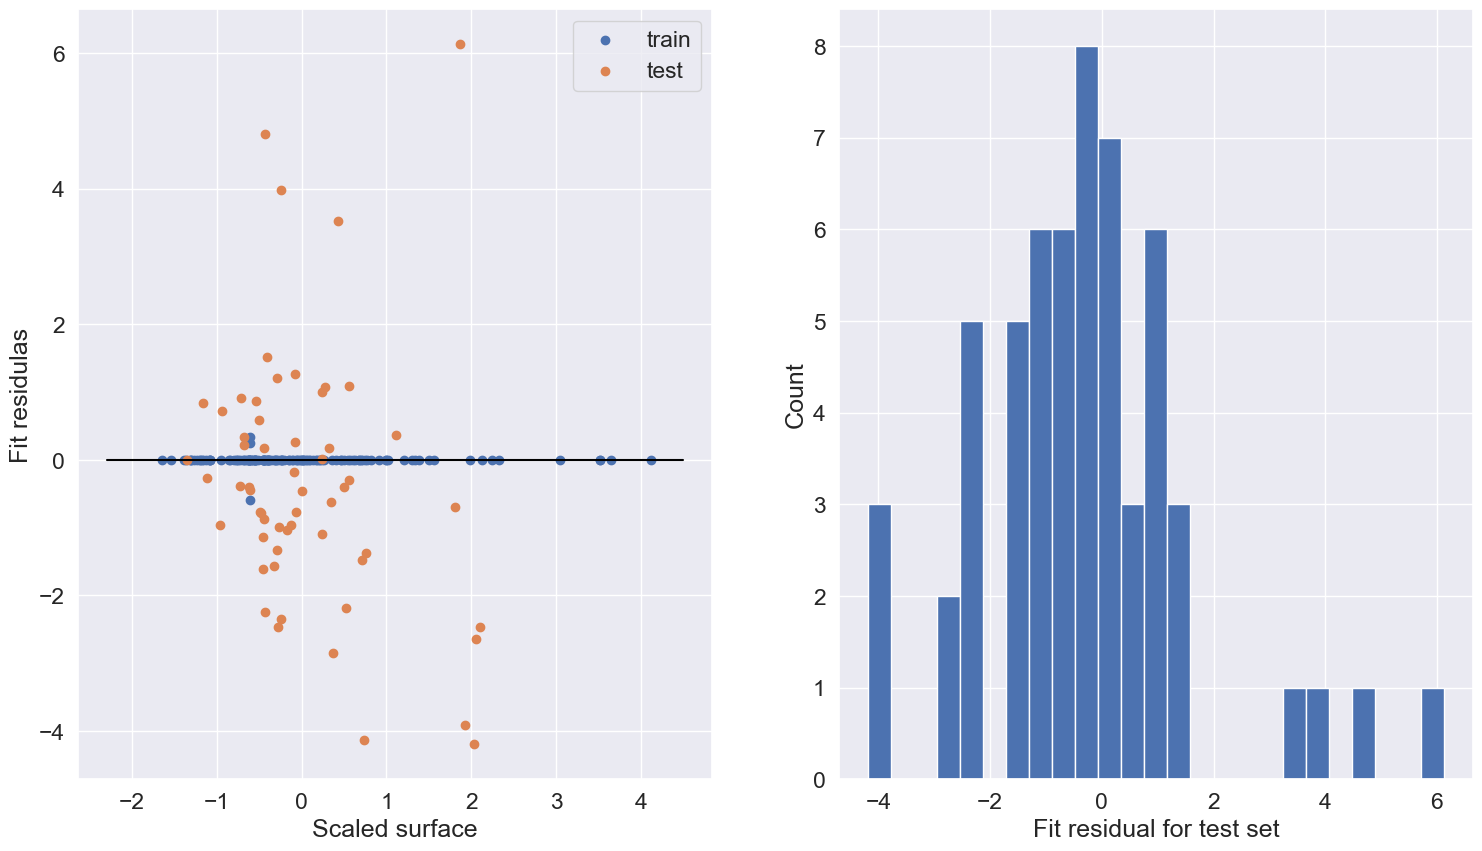

mean residuals: -0.33 
std: 1.9


In [ ]:
# plot the residuals
plotResidue(knn_cv, X, y, rs=rs)

In [ ]:
from sklearn.model_selection import validation_curve
param_range = range(1,31)
knn_cv = KNeighborsRegressor()
train_scores, val_scores = validation_curve(knn_cv, 
                                             X_train, y_train, 
                                             param_name="n_neighbors",
                                             param_range=param_range,
                                             n_jobs=-1,
                                             scoring="neg_mean_squared_error", 
                                             cv=10
                                            )

In [ ]:
train_scores.shape

(30, 10)

In [ ]:
train_mean_score = -np.mean(train_scores, axis=1)
val_mean_score = -np.mean(val_scores, axis=1)

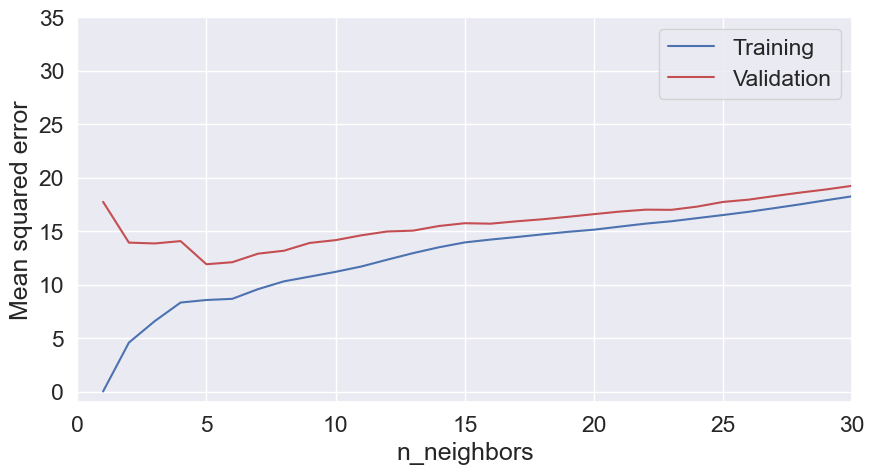

In [ ]:
fig, ax = plt.subplots(figsize=(10,5))
plt.plot( param_range, train_mean_score, color="b", label="Training" )
plt.plot( param_range, val_mean_score, color="r", label="Validation" )
plt.xlim(1,15)
plt.xlabel( "n_neighbors" )
plt.ylim(-1, 35)
plt.xlim(0, 30)
plt.ylabel( "Mean squared error" )
plt.legend()
plt.show()

No handles with labels found to put in legend.


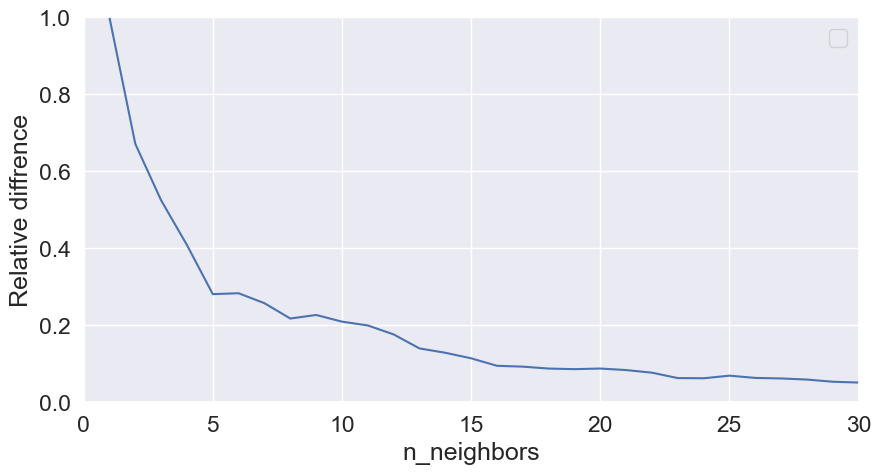

In [ ]:
fig, ax = plt.subplots(figsize=(10,5))
plt.plot( param_range, (val_mean_score-train_mean_score)/val_mean_score )
plt.xlim(1,15)
plt.xlabel( "n_neighbors" )
plt.ylim(0, 1)
plt.xlim(0, 30)
plt.ylabel( "Relative diffrence" )
plt.legend()
plt.show()

In [ ]:
knn_cv = KNeighborsRegressor(n_neighbors=20, weights="uniform")
knn_cv.fit( X_train, y_train )
y_pred_knn = knn_cv.predict(X_test)
print(r2_score(y_train, knn_cv.predict(X_train)) , r2_score(y_test, y_pred_knn))
mean_squared_error(y_train, knn_cv.predict(X_train)) , mean_squared_error(y_test, y_pred_knn) 

0.6343407725324247 0.7857417151691483


(14.813125659116542, 4.201418297715517)

In [ ]:
from sklearn.model_selection import cross_val_score
cross_val_list = cross_val_score(knn_cv, X_train, y_train, 
                                 scoring="neg_mean_squared_error", cv=10)
score_val_knn = -np.mean(cross_val_list)
score_val_knn

16.58823032363599

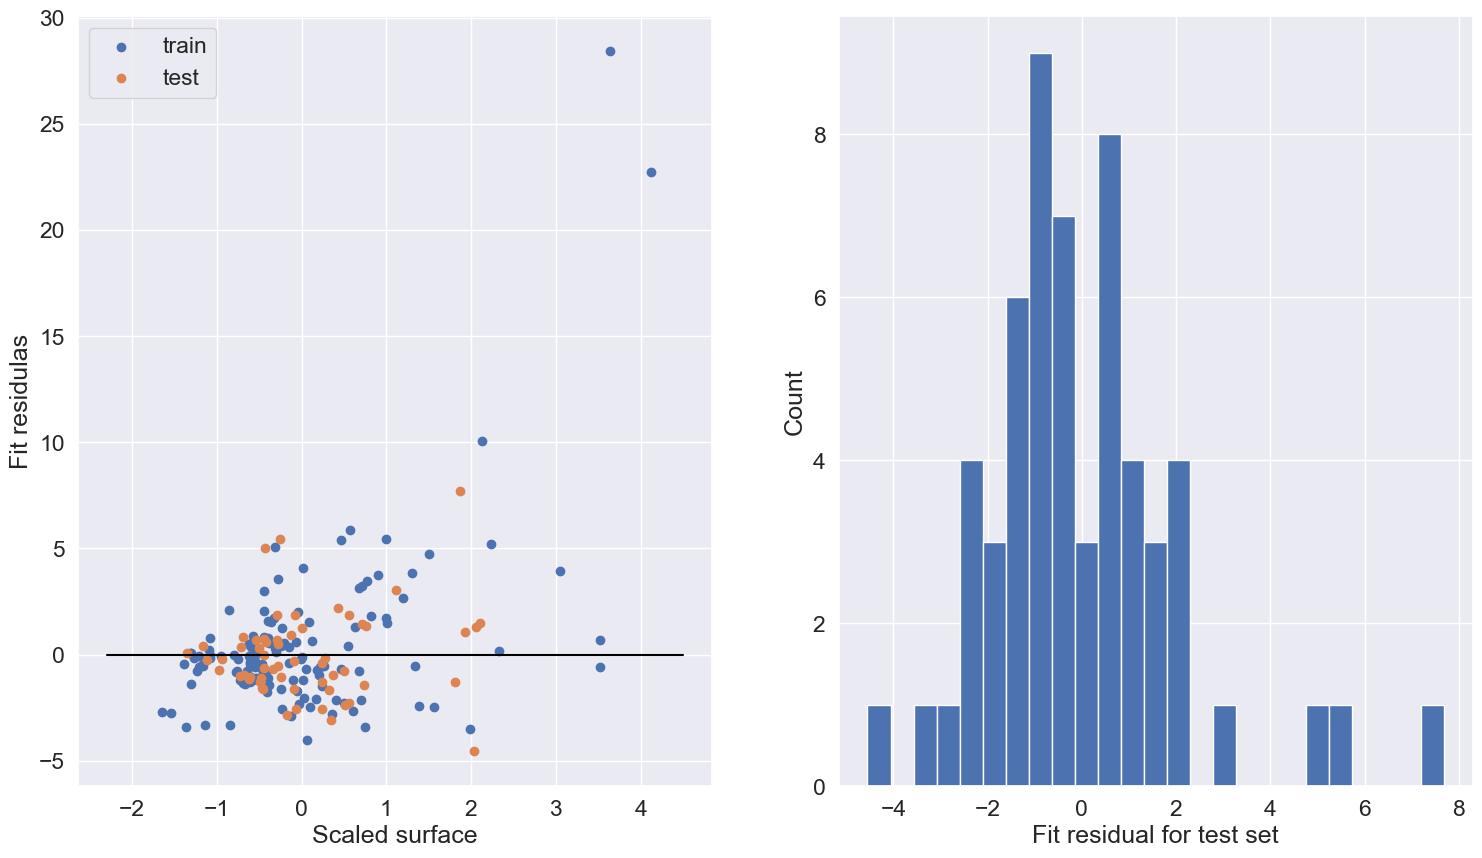

mean residuals: -0.02 
std: 2.05


In [ ]:
# plot the residuals
plotResidue(knn_cv, X, y, rs=rs)

## Suport Vector Regression

In [ ]:
# SVR model
svr = SVR()
pg = {
    "kernel": ['linear', 'poly', 'rbf', 'sigmoid'],
    "gamma": ['scale', 'auto'], # Kernel coefficient 
    "C": np.logspace(-3, 3, 10), # Penalty parameter
    "epsilon": np.linspace(.1, 1., 10) # the decision boundary
}
svr_cv = gridSearchReport( svr, X, y, pg, cv=10, rs=rs )


Best parameters: {'C': 2.154434690031882, 'epsilon': 0.2, 'gamma': 'scale', 'kernel': 'linear'}
Best CV score: 9.356070885265115
MSE, R2 train: 9.067544243899928 ,  0.7761693717077229
MSE, R2 test: 3.2248964453597293 ,  0.8355410644268413
Elapsed time: 88.03 s , 1.47 min


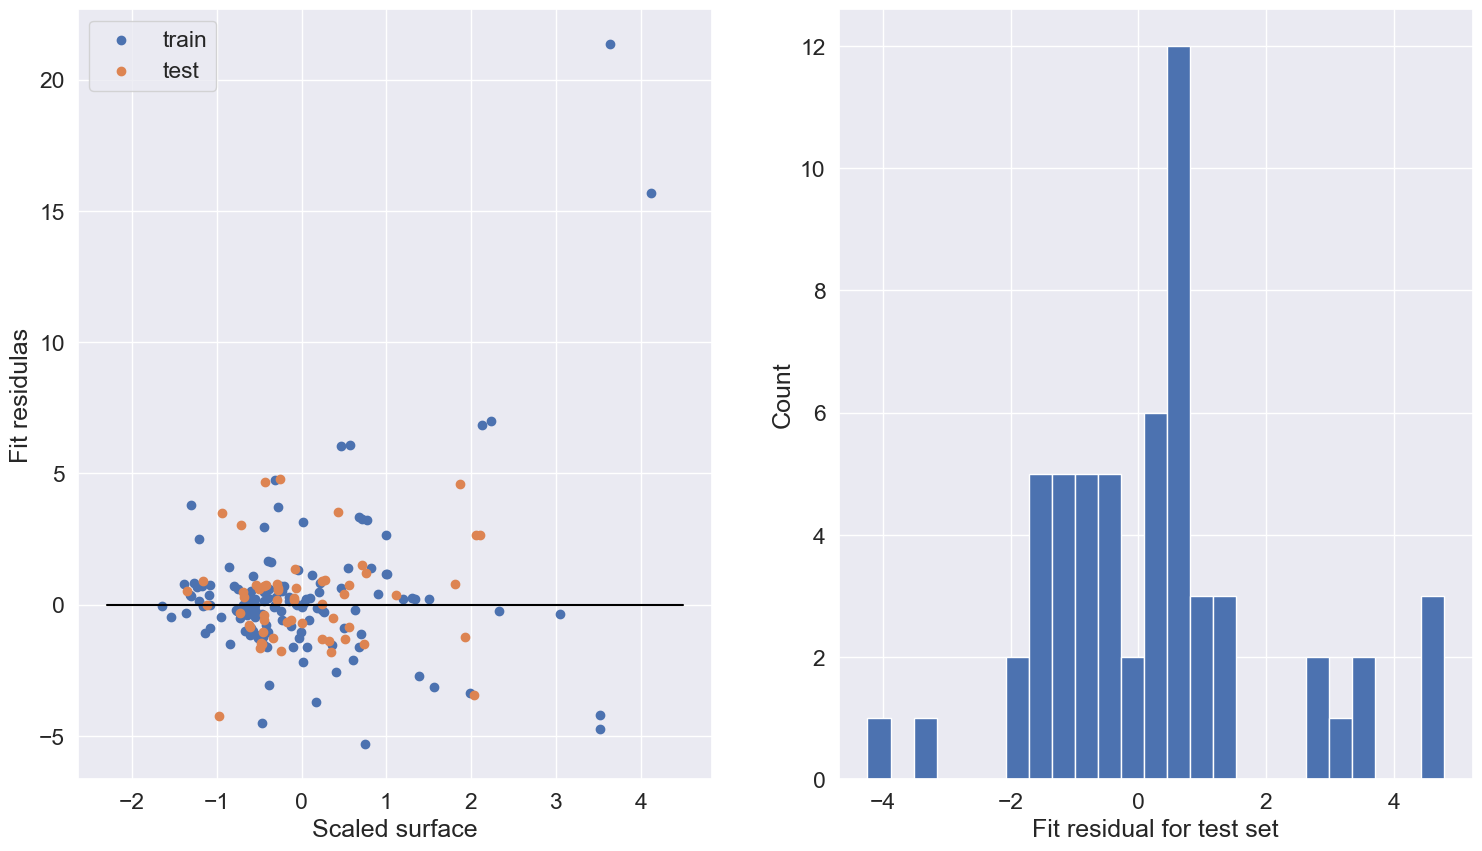

mean residuals: 0.26 
std: 1.78


In [ ]:
# plot the residuals
plotResidue(svr_cv, X, y, rs=rs)

## Comparing the estimators

In [ ]:
# fcuntions to make a comparision between all the models
def sortXy( X, y ):
    """
    Prepares the features to have the fit only for "surface" variable. 
    """ 
    df = X.copy()
    df["price"] = y
    df = df.sort_values("surface").reset_index(drop=True)
    return df.drop(columns=["price"]), df["price"]

#######################################
def get_scores( X, y, est_name, est ):
    """
    Computes the validation and tets scores. 
    Params:
        X: Pandas dataframe, feature data
        y: Pandas series, target
        est_name: str
            estromator name
        est: regressor
            the regression estimator
    Return:
        r2 for the test sample, mse for validation sample and the labels for plotting.
    """    
    y_pred = est.predict(X)
    r2_test = round(r2_score(y, y_pred), 1)
    if est_name=="Linear Regression" :
        mse_cv = "--"
    elif est_name=="Extreme Gradient Boosting":
        mse_cv = round(df_grid_best["val_score"].to_list()[0],1)
    elif est_name=="K-Nearest Neighbors Regression":
        mse_cv = round(score_val_knn,1)
    else :
        mse_cv=round(abs(est.best_score_), 1)
    
    lbl = est_name+":  R2_test="+str(r2_test)+", MSE_cv="+str(mse_cv)
    
    return r2_test, mse_cv, lbl

    
#######################################
def plotLines( X, y, estimators, rs):
    """
    Plots the fitted curve for the given estimators to test data vs. "surface" variable.
    Params:
        X: Pandas dataframe 
            features 
        y: Pandas series 
            target
        estimators: list 
            list of regressors
        rs: int 
            random state
    """    
    X, y = sortXy( X, y )
    colors = ["k", "b", "r", "g"]
    fig, axe = plt.subplots(figsize=(20,10))
    axe.scatter( X["surface"], y )
    i = 0
    for k, estimator  in estimators.items():
        r2_test, mse_cv, label = get_scores( X, y, k, estimator )
        axe.plot(X["surface"], estimator.predict(X), label=label, c=colors[i])
        i+=1
    axe.set_xlabel("Scaled surface")
    axe.set_ylabel("Price in millions")
    axe.legend()



In [ ]:
estimators1 = {
              "Linear Regression": lr, 
              "Ridge Regression": ridg_cv, 
              "Lasso Regression": lasso_cv, 
              "Elastic Net": elastic_cv, 
}

estimators2 = {              
              "Random Forest Regression": rfr_cv, 
              "Extreme Gradient Boosting": xgbr, 
              "K-Nearest Neighbors Regression": knn_cv, 
              "Support Vector Regression": svr_cv
}



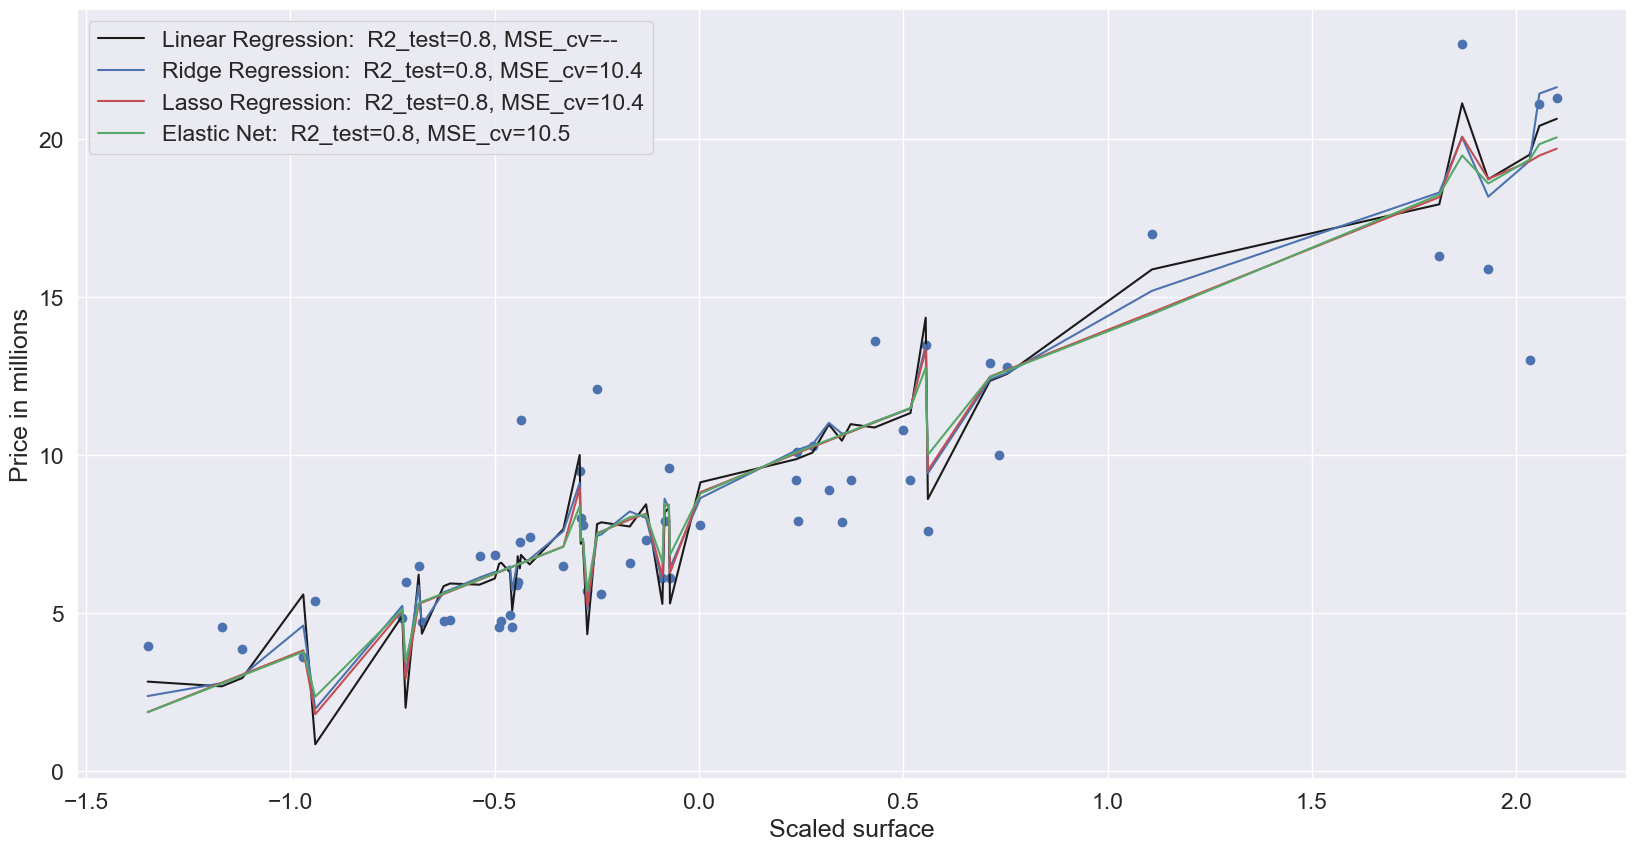

In [ ]:
plotLines(X_test ,y_test, estimators1, rs=rs)

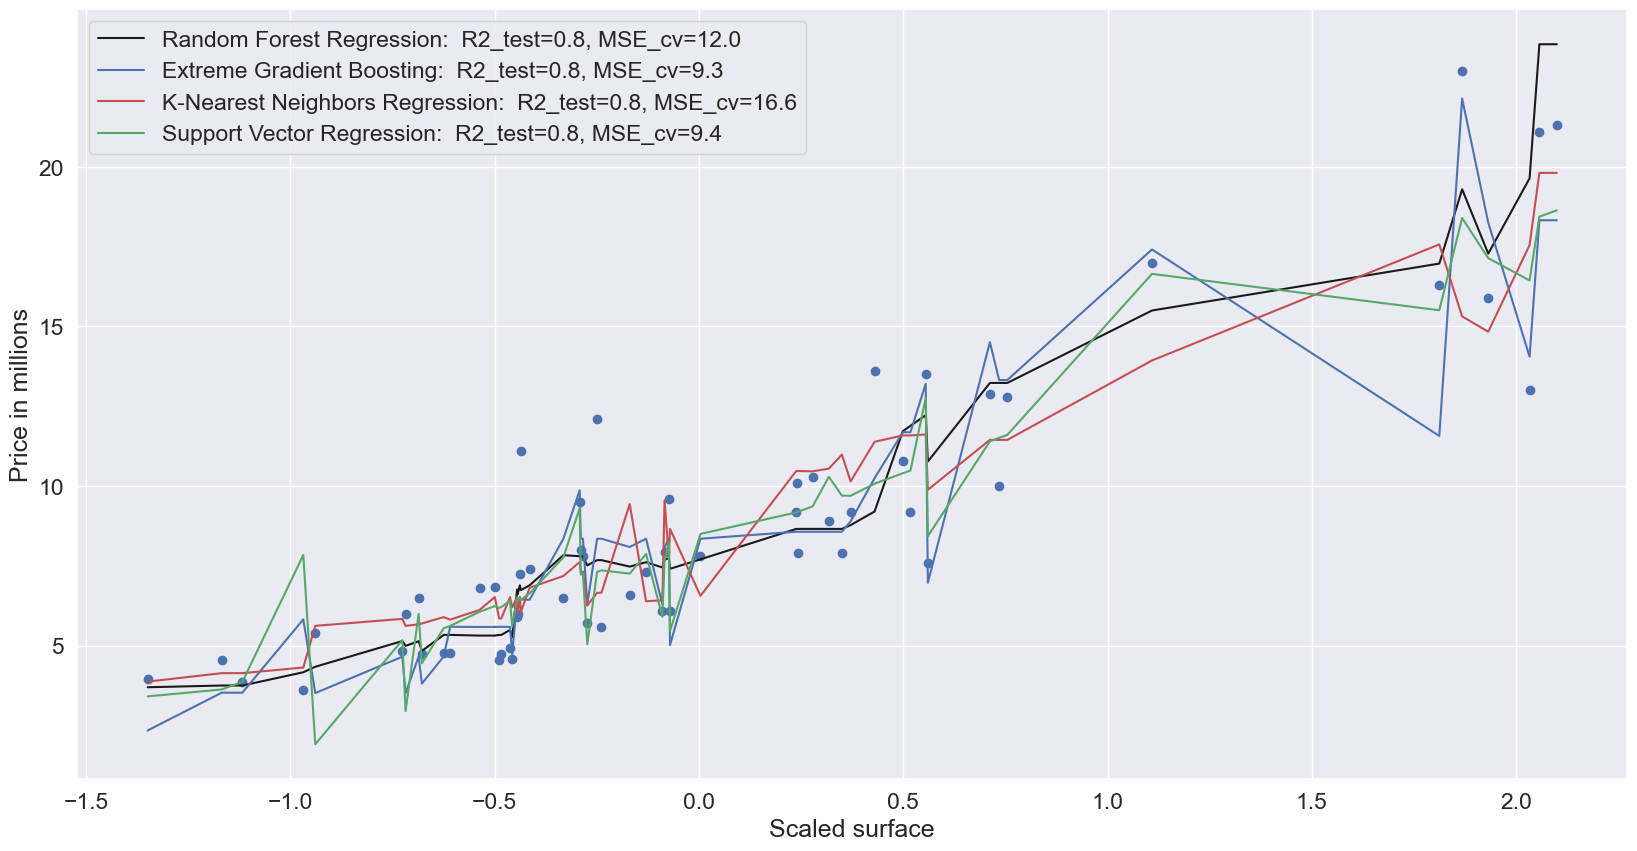

In [ ]:
plotLines(X_test,y_test, estimators2, rs=rs)

# Conclusion

We have conclude that our best estimator at first is the  - 

Extreme Gradient boosting 

followd by Support Vector Regressor and then the Linear regression methods